# Seashells

This is a Jupyter Notebook implementation of b-g-goodell's iseeseashells project https://github.com/b-g-goodell/research-lab/blob/master/source-code/iseeseashells/seashells.py

This notebook by [IsthmusCrypto](https://github.com/mitchellpkt)

## Import libraries

In [1]:
from hashlib import blake2b
import math
import random
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

## Define necessary functions

In [2]:
def getBlakeDigests(inputAddress):
    ''' Take as input some inputAddress and produce as output a hash digest. Not quite an HMAC.'''
    h = blake2b()
    h.update(str("iseeseashells").encode("utf-8"))
    tempOne = str(h.digest())

    h = blake2b()
    h.update(str("downbytheseashore").encode("utf-8"))
    tempTwo = str(h.digest())

    h = blake2b()
    h.update(tempOne.encode("utf-8"))
    h.update(inputAddress.encode("utf-8"))
    tempThree = str(h.digest())

    h = blake2b()
    h.update(tempTwo.encode("utf-8"))
    h.update(tempThree.encode("utf-8"))
    d = h.digest()
    return d

In [3]:
def getParams(d):
    ''' Take as input a hash digest, interprets it bytewise as integers, returns params. '''
    params = {"semiAxisOneInit": None, "frequencyOne": None, "wobbleOne": None, "frequencyTwo": None, "wobbleTwo": None,
              "semiAxisTwoInit": None, "radiusInit": None, "heightInit":None, "growth": None, "heightChangeConst":None}

    # Initial radius spatial parameter (determines centerline of logarithmic spiral)
    # Drawn from minFloatParam to maxFloatParam
    next = d[:4]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = float(nextInt)*(2.0**-32)
    assert 0.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = minFloatParam + (maxFloatParam - minFloatParam)*nextFloat
    params.update({"radiusInit":nextParam}) # float, [minFloatParam, maxFloatParam)

    # Initial height spatial parameter (determines centerline of logarithmic spiral)
    # Drawn from minFloatParam to maxFloatParam
    next = d[4:8]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = float(nextInt)*(2.0**-32)
    assert 0.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = minFloatParam + (maxFloatParam - minFloatParam)*nextFloat
    params.update({"heightInit":nextParam}) # float, [minFloatParam, maxFloatParam)

    # Ellipse-semi-axis-one initial spatial parameter.
    # Drawn from 0.0 to radiusInit
    next = d[8:12]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = float(nextInt)*(2.0**-32)
    assert 0.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = params["radiusInit"]*nextFloat
    params.update({"semiAxisOneInit":nextParam}) # float, [minFloatParam, maxFloatParam)

    # Ellipse-semi-axis-two initial spatial parameter.
    # Drawn from -math.sqrt(params["radiusInit"]**2 - params["semiAxisOneInit"]**2) to math.sqrt(params["radiusInit"]**2 - params["semiAxisOneInit"]**2)
    next = d[12:16]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = float(nextInt)*(2.0**-32)
    assert 0.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = math.sqrt(params["radiusInit"]**2 - params["semiAxisOneInit"]**2)*nextFloat
    params.update({"semiAxisTwoInit":nextParam}) # float, [maxFloatParam, maxFloatParam)

    # Spatial frequency at which the ellipse spins its orientation.
    # Drawn from minFrequency to maxFrequency
    next = d[16:20]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = float(nextInt)*(2.0**-32)
    assert 0.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = minFrequency + (maxFrequency - minFrequency)*nextFloat
    params.update({"frequencyOne":nextParam}) # float, [minFrequency, maxFrequency)

    # Spatial frequency at which the cross section of the shell wobbles/shell ridges
    # Drawn from minFrequency to maxFrequency
    next = d[20:24]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = float(nextInt)*(2.0**-32)
    assert 0.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = minFrequency + (maxFrequency - minFrequency)*nextFloat
    params.update({"frequencyTwo":nextParam}) # float, [maxFrequency, maxFrequency)

    # Relative spatial amount of wobble along first semi-axis
    # Drawn from -1.0 to 1.0
    next = d[24:28]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = 2.0*float(nextInt)*(2.0**-32) - 1.0
    assert -1.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = nextFloat
    params.update({"wobbleOne":nextFloat}) # float, (-1, 1)

    # Relative spatial amount of wobble along second semi-axis
    # Drawn from -1.0*math.sqrt(1.0 - wobbleOne**2) to 1.0*math.sqrt(1.0 - wobbleOne**2)
    next = d[28:32]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = 2.0*float(nextInt)*(2.0**-32) - 1.0
    assert -1.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = math.sqrt(1.0 - params["wobbleOne"]**2)*nextFloat
    params.update({"wobbleTwo":nextParam}) # float, (-1+sqrt(1-wobbleOne**2), 1-sqrt(1-wobbleOne**2))

    # Logarithmic growth rate.
    # Drawn from -maxGrowthRate to +maxGrowthRate
    # Different growth rate for different things can lead to ugly seashells...
    # but having more parameters squeezed out of an address hash means the result
    # is less likely to produce a convincing visual near-duplicate... so
    # TODO: different growth rates for different things?
    # Can work but only if we restrict our random parameter generation to "pretty" subspaces.
    next = d[32:36]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = 2.0*float(nextInt)*(2.0**-32) - 1.0
    assert -1.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = nextFloat*maxGrowthRate
    params.update({"growth":nextParam}) # float, [1.0/maxGrowthRate, maxGrowthRate)

    # Constant drift of height. If this is large, then you get a long cone-shaped shell.
    # If this is small, you get a clam.
    # Drawn from 0.0 to maxHeightDrift
    next = d[36:40]
    nextInt = int.from_bytes(next, byteorder='big')
    nextFloat = float(nextInt)*(2.0**-32)
    assert 0.0 <= nextFloat
    assert nextFloat < 1.0
    nextParam = nextFloat*maxHeightDrift
    params.update({"heightChangeConst":nextParam}) # float, [1.0/maxGrowthRate, maxGrowthRate)

    return params

In [4]:
def getFunctions(inputAddress):
    ''' Takes as input some inputAddress, computes params, and returns params with some ambda functions describing
        the parameterization of the resulting shell. To derive these functions: take the parameterization of an ellipse,
        x = a*cos(s), y = b*sin(s); scale this vector by (1 + c1*cos(s) + c2*sin(s)); multiply the resulting vector
        by a rotation matrix with angle f*s for some frequency f. Make the substitution x = r and y = z (or vice versa);
        embed (r,z) into cylindrical space (r,z,t); Lastly, and this is very important: translate the result to be
        centered on the centerline of the shell.'''
    d = getBlakeDigests(inputAddress)
    params = getParams(d)
    theta = lambda inp:inp[0]
    radius = lambda inp:((params["semiAxisOneInit"]*math.cos(params["frequencyOne"]*inp[0])*math.cos(inp[1])*(1.0+params["wobbleOne"]*math.cos(params["frequencyTwo"]*inp[1]) + params["wobbleTwo"]*math.sin(params["frequencyTwo"]*inp[1])) - params["semiAxisTwoInit"]*math.sin(params["frequencyOne"]*inp[0])*math.sin(inp[1])*(1.0+params["wobbleOne"]*math.cos(params["frequencyTwo"]*inp[1]) + params["wobbleTwo"]*math.sin(params["frequencyTwo"]*inp[1])) - params["radiusInit"])*math.exp(params["growth"]*inp[0]))
    height = lambda inp:(params["heightChangeConst"]*inp[0] + ((params["semiAxisOneInit"]*math.sin(params["frequencyOne"]*inp[0])*math.cos(inp[1])*(1.0+params["wobbleOne"]*math.cos(params["frequencyTwo"]*inp[1]) + params["wobbleTwo"]*math.sin(params["frequencyTwo"]*inp[1])) + params["semiAxisTwoInit"]*math.cos(params["frequencyOne"]*inp[0])*math.sin(inp[1])*(1.0+params["wobbleOne"]*math.cos(params["frequencyTwo"]*inp[1]) + params["wobbleTwo"]*math.sin(params["frequencyTwo"]*inp[1])) - params["heightInit"])*math.exp(params["growth"]*inp[0])))
    return params, theta, radius, height

In [5]:
def seeseashell(inputAddress, cmap='gnuplot2'):
    ''' Takes as input some inputAddress, computes getFunctions, and plots the resulting shell.'''
    if type(inputAddress) != type(str(1)):
        inputAddress = str(inputAddress)
    params, theta, radius, height = getFunctions(inputAddress)

    U = np.linspace(0.0, 2.0*math.pi, 256)
    T = np.linspace(math.pi/6.0, 2.0*math.pi*3.0, 256)
    X = []
    Y = []
    surf = []
    for i in range(len(U)):
        u = U[i]
        surf.append([])
        X.append([])
        Y.append([])
        for j in range(len(T)):
            t = T[j]
            z = height([t,u])
            r = radius([t,u])
            x = r * math.cos(t)
            y = r * math.sin(t)
            X[-1].append(x)
            Y[-1].append(y)
            surf[-1].append(z)
    X = np.array(X)
    Y = np.array(Y)
    surf = np.array(surf)

    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
    ax = fig.gca(projection='3d')
    # Plot the surface with face colors taken from the array we made.
    surf_obj = ax.plot_surface(X, Y, surf, cmap=cmap)
                              
    print(params)
    plt.show()
    
    return(fig, X, Y, surf, surf_obj)

## Set global parameters
Further fine-tuning of these will improve shell quality.

In [6]:
minFloatParam = 2.0**-3
maxFloatParam = 2.0**3
minFrequency = 2.0**-2
maxFrequency = 2.0**2
maxGrowthRate = 0.2
maxHeightDrift = 1.0

## Generate a seashell

{'semiAxisOneInit': 2.795478678789031, 'frequencyOne': 1.1743413829244673, 'wobbleOne': -0.19769954914227128, 'frequencyTwo': 2.5601456614676863, 'wobbleTwo': -0.5072481730009125, 'semiAxisTwoInit': 0.11385461875361745, 'radiusInit': 7.601132765499642, 'heightInit': 0.15119932522065938, 'growth': 0.15135350581258536, 'heightChangeConst': 0.2667851182632148}


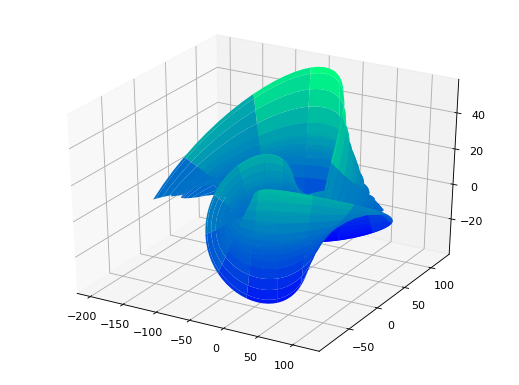

In [7]:
ssfig, X, Y, surf, surf_obj = seeseashell("UNCAGED_POTENTIAL", cmap='winter')